In [2]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# What is the expected global water demand?

In [3]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)
mm_per_s_to_mm_per_day = 86400.0

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_per_s_to_mm_per_day*mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lon_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

In [4]:
import numpy as np
import xarray as xr

# Read the output data for the simulation with sector water usage on
path_simulation_data_with_sector_water_abstractions = "/glade/work/staranu/paper1_data_simulations/paper1_sectorwater_run.clm2.h1.1971-2010.nc"
output_data_sectorwater_simulation = xr.open_dataset(path_simulation_data_with_sector_water_abstractions, decode_times=False)

# Define an array to store global annual withdrawal and consumption amounts for each sector
time_series_global_water_abstraction_fluxes = np.zeros((11,38))

# Define the list of variables we want to compute total annual amount for
list_of_variables_to_extract = ["DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD", "DOM_EXPECTED_CONS", "LIV_EXPECTED_CONS", "ELEC_EXPECTED_CONS", "MFC_EXPECTED_CONS", "MIN_EXPECTED_CONS", "QIRRIG_DEMAND"]

# Initialize time window
init_time = 365*2
end_time = 365*3
step = 365

for year in range(1973, 2011):
    for variable in range(0, 11):
        time_series_global_water_abstraction_fluxes[variable, year-1973] = np.nansum(output_data_sectorwater_simulation[list_of_variables_to_extract[variable]][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform)
        
    end_time += step
    init_time += step

    print("Year completed: " + str(year))


Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


In [5]:
data_cumulative = np.cumsum(time_series_global_water_abstraction_fluxes, axis=0)

variable_names = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining", "Irrigation"]
zero_line = np.zeros(38)
normal_line = np.ones(38)*(-1.0)
interupted_line = np.ones(38)*(-1.0)
years = np.linspace(1973,2010,38)

# plot the cumulative data as a line plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(years, time_series_global_water_abstraction_fluxes[10], label=variable_names[5], color="#70ad47")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], label=variable_names[0], color="#4472c4")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], label=variable_names[1], color="#c55a11")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], label=variable_names[2], color="#ffc000")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], label=variable_names[3], color="#ff3300")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[4], label=variable_names[4], color="#000000")

ax.fill_between(years, zero_line,  time_series_global_water_abstraction_fluxes[10], alpha=0.1, color='#70ad47')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10], time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], alpha=0.1, color='#4472c4')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], alpha=0.1, color='#c55a11') 
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], alpha=0.1, color='#ffc000') 
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], alpha=0.1, color='#ff3300') 
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], time_series_global_water_abstraction_fluxes[10] + data_cumulative[4], alpha=0.1, color='#000000')



# Set larger font sizes for all text elements
ax.tick_params(labelsize=16)
leg  = ax.legend(fontsize=16)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Expected Water Withdrawal [km$^3$/year]", fontsize=18)
ax.set_xlim(1973,2010)
ax.set_ylim(0,7000)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
    
print("Total sectoral withdrawal (except irrigation) in 2010 is: " + str(np.round(data_cumulative[4,-1],0)) + " km3/year")
print("Total sectoral consumption (except irrigation) in 2010 is: " + str(np.round(data_cumulative[9,-1]-data_cumulative[4,-1],0)) + " km3/year")
print("Total increase in sectoral withdrawal (except irrigation) between the period 1973-2010 is about: " + str(np.round(data_cumulative[4,-1] - data_cumulative[4,0],0)) + " km3/year. A relative increase of " + str(np.round((data_cumulative[4,-1] - data_cumulative[4,0])/data_cumulative[4,0]*100,0)) + "%")

Total sectoral withdrawal (except irrigation) in 2010 is: 1157.0 km3/year
Total sectoral consumption (except irrigation) in 2010 is: 171.0 km3/year
Total increase in sectoral withdrawal (except irrigation) between the period 1973-2010 is about: 315.0 km3/year. A relative increase of 37.0%


In [6]:
dom_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[0][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]
liv_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[1][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]
elec_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[2][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]
mfc_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[3][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]
min_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[4][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]
irrig_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes[10][-1]/(time_series_global_water_abstraction_fluxes[0]+time_series_global_water_abstraction_fluxes[1]+time_series_global_water_abstraction_fluxes[2]+time_series_global_water_abstraction_fluxes[3]+time_series_global_water_abstraction_fluxes[4]+time_series_global_water_abstraction_fluxes[10])[-1]


print("Relative importance of domestic sector in 2010 is: " + str(dom_relative_importance_2010) + "%")
print("Relative importance of livestock sector in 2010 is: " + str(liv_relative_importance_2010) + "%")
print("Relative importance of thermoelectric sector in 2010 is: " + str(elec_relative_importance_2010) + "%")
print("Relative importance of manufacturing sector in 2010 is: " + str(mfc_relative_importance_2010) + "%")
print("Relative importance of mining sector in 2010 is: " + str(min_relative_importance_2010) + "%")
print("Relative importance of irrigation sector in 2010 is: " + str(irrig_relative_importance_2010) + "%")

Relative importance of domestic sector in 2010 is: 6.940629422898928%
Relative importance of livestock sector in 2010 is: 1.6608065932722047%
Relative importance of thermoelectric sector in 2010 is: 6.0419827637865575%
Relative importance of manufacturing sector in 2010 is: 3.8286014527992216%
Relative importance of mining sector in 2010 is: 0.3365520293181676%
Relative importance of irrigation sector in 2010 is: 81.19142773792493%


In [7]:
mean_dom_withd = np.nanmean(time_series_global_water_abstraction_fluxes[0])
print("Mean dom withd: " + str(np.round(mean_dom_withd,0)) + str(" km3/year"))

mean_liv_withd = np.nanmean(time_series_global_water_abstraction_fluxes[1])
print("Mean liv withd: " + str(np.round(mean_liv_withd,0)) + str(" km3/year"))

mean_elec_withd = np.nanmean(time_series_global_water_abstraction_fluxes[2])
print("Mean elec withd: " + str(np.round(mean_elec_withd,0)) + str(" km3/year"))

mean_mfc_withd = np.nanmean(time_series_global_water_abstraction_fluxes[3])
print("Mean mfc withd: " + str(np.round(mean_mfc_withd,0)) + str(" km3/year"))

mean_min_withd = np.nanmean(time_series_global_water_abstraction_fluxes[4])
print("Mean min withd: " + str(np.round(mean_min_withd,0)) + str(" km3/year"))

mean_irrig_withd = np.nanmean(time_series_global_water_abstraction_fluxes[10])
print("Mean irrig withd: " + str(np.round(mean_irrig_withd,0)) + str(" km3/year"))

Mean dom withd: 306.0 km3/year
Mean liv withd: 89.0 km3/year
Mean elec withd: 359.0 km3/year
Mean mfc withd: 229.0 km3/year
Mean min withd: 20.0 km3/year
Mean irrig withd: 3895.0 km3/year


In [8]:
mean_rel_dom_importance = 100 * mean_dom_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean dom rel importance: " + str(np.round(mean_rel_dom_importance,1)) + "%")

mean_rel_liv_importance = 100 * mean_liv_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean liv rel importance: " + str(np.round(mean_rel_liv_importance,1)) + "%")

mean_rel_elec_importance = 100 * mean_elec_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean elec rel importance: " + str(np.round(mean_rel_elec_importance,1)) + "%")

mean_rel_mfc_importance = 100 * mean_mfc_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean mfc rel importance: " + str(np.round(mean_rel_mfc_importance,1)) + "%")

mean_rel_min_importance = 100 * mean_min_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean min rel importance: " + str(np.round(mean_rel_min_importance,1)) + "%")

mean_rel_irrig_importance = 100 * mean_irrig_withd/(mean_dom_withd+mean_liv_withd+mean_elec_withd+mean_mfc_withd+mean_min_withd+mean_irrig_withd)
print("Mean irrig rel importance: " + str(np.round(mean_rel_irrig_importance,1)) + "%")

Mean dom rel importance: 6.2%
Mean liv rel importance: 1.8%
Mean elec rel importance: 7.3%
Mean mfc rel importance: 4.7%
Mean min rel importance: 0.4%
Mean irrig rel importance: 79.5%


In [9]:
data_cumulative = np.cumsum(time_series_global_water_abstraction_fluxes, axis=0)

variable_names = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining"]
zero_line = np.zeros(38)
normal_line = np.ones(38)*(-1.0)
interupted_line = np.ones(38)*(-1.0)
years = np.linspace(1973,2010,38)

# plot the cumulative data as a line plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(years, data_cumulative[0], label=variable_names[0], color="orange")
ax.plot(years, data_cumulative[1], label=variable_names[1], color="green")
ax.plot(years, data_cumulative[2], label=variable_names[2], color="red")
ax.plot(years, data_cumulative[3], label=variable_names[3], color="purple")
ax.plot(years, data_cumulative[4], label=variable_names[4], color="brown")

ax.fill_between(years, zero_line, data_cumulative[0], alpha=0.1, color='orange')
ax.fill_between(years, data_cumulative[0], data_cumulative[1], alpha=0.1, color='green')
ax.fill_between(years, data_cumulative[1], data_cumulative[2], alpha=0.1, color='red')
ax.fill_between(years, data_cumulative[2], data_cumulative[3], alpha=0.1, color='purple')
ax.fill_between(years, data_cumulative[3], data_cumulative[4], alpha=0.1, color='brown')

ax.plot(years, data_cumulative[0]-time_series_global_water_abstraction_fluxes[5], ls=':', color='orange')
ax.plot(years, data_cumulative[0]+(time_series_global_water_abstraction_fluxes[1] - time_series_global_water_abstraction_fluxes[6]), ls=':', color='green')
ax.plot(years, data_cumulative[1]+(time_series_global_water_abstraction_fluxes[2] - time_series_global_water_abstraction_fluxes[7]), ls=':', color='red')
ax.plot(years, data_cumulative[2]+(time_series_global_water_abstraction_fluxes[3] - time_series_global_water_abstraction_fluxes[8]), ls=':', color='purple')
ax.plot(years, data_cumulative[3]+(time_series_global_water_abstraction_fluxes[4] - time_series_global_water_abstraction_fluxes[9]), ls=':', color='brown')
ax.plot(years, normal_line, label="Withdrawal", color = 'k')
ax.plot(years, interupted_line, label="Return Flow", ls=':', color = 'k')

# Set larger font sizes for all text elements
ax.tick_params(labelsize=16)
leg  = ax.legend(fontsize=16)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Expected Water Withdrawal [km$^3$/year]", fontsize=18)
ax.set_xlim(1973,2010)
ax.set_ylim(0,1800)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)
    
plt.savefig("Results/png_format/Global_sectoral_expected_withdrawal_and_return_flow_fraction.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)


# What is the actual global water withdrawal?

In [10]:
# Define an array to store global annual actual withdrawal
time_series_global_water_abstraction_fluxes_actual = np.zeros((11, 38))

# Define the list of variables we want to compute total annual amount for
list_of_variables_to_extract = ["DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD", "DOM_ACTUAL_CONS", "LIV_ACTUAL_CONS", "ELEC_ACTUAL_CONS", "MFC_ACTUAL_CONS", "MIN_ACTUAL_CONS", "QIRRIG_FROM_SURFACE"]

# Initialize time window
init_time = 365*2
end_time = 365*3
step = 365

for year in range(1973, 2011):
    for variable in range(0, 11):
        time_series_global_water_abstraction_fluxes_actual[variable, year - 1973] = np.nansum(output_data_sectorwater_simulation[list_of_variables_to_extract[variable]][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform)
    
   
    end_time += step
    init_time += step

    print("Year completed: " + str(year))


Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


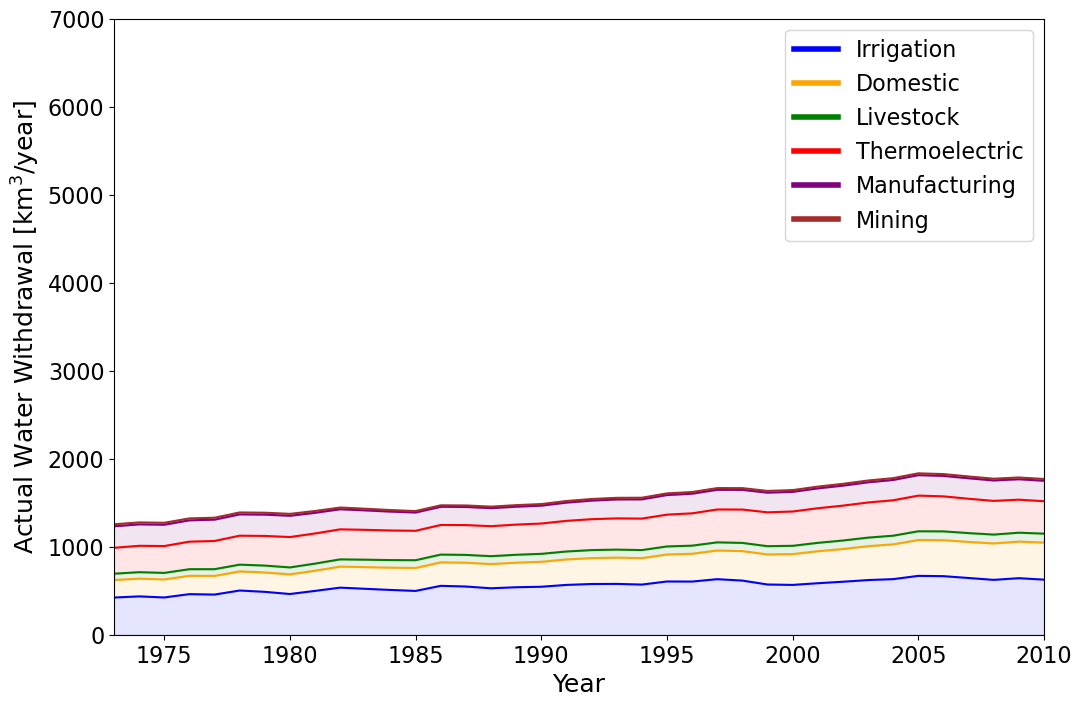

In [12]:
data_cumulative = np.cumsum(time_series_global_water_abstraction_fluxes_actual, axis=0)
variable_names = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining", "Irrigation"]
zero_line = np.zeros(38)
normal_line = np.ones(38)*(-1.0)
interupted_line = np.ones(38)*(-1.0)
years = np.linspace(1973,2010,38)

# plot the cumulative data as a line plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10], label=variable_names[5], color="blue")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], label=variable_names[0], color="orange")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], label=variable_names[1], color="green")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], label=variable_names[2], color="red")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], label=variable_names[3], color="purple")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[4], label=variable_names[4], color="brown")

ax.fill_between(years, zero_line,  time_series_global_water_abstraction_fluxes_actual[10], alpha=0.1, color='blue')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], alpha=0.1, color='orange')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], alpha=0.1, color='green')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], alpha=0.1, color='red')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], alpha=0.1, color='purple')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[4], alpha=0.1, color='brown')



# Set larger font sizes for all text elements
ax.tick_params(labelsize=16)
leg  = ax.legend(fontsize=16)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Actual Water Withdrawal [km$^3$/year]", fontsize=18)
ax.set_xlim(1973,2010)
ax.set_ylim(0,7000)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

In [13]:
diff_1973_2010 = (time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1] - (time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[0]
relative_diff_1973_2010 = 100*((time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1] - (time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[0])/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[0]
print("Change in expected withdrawal between 1973 and 2010: " + str(diff_1973_2010) + " km3/year")
print("Relative change in expected withdrawal between 1973 and 2010: " + str(relative_diff_1973_2010) + "%")


Change in expected withdrawal between 1973 and 2010: 514.659235038549 km3/year
Relative change in expected withdrawal between 1973 and 2010: 41.012194086134386%


In [14]:
dom_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[0][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]
liv_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[1][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]
elec_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[2][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]
mfc_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[3][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]
min_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[4][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]
irrig_relative_importance_2010 = 100*time_series_global_water_abstraction_fluxes_actual[10][-1]/(time_series_global_water_abstraction_fluxes_actual[0]+time_series_global_water_abstraction_fluxes_actual[1]+time_series_global_water_abstraction_fluxes_actual[2]+time_series_global_water_abstraction_fluxes_actual[3]+time_series_global_water_abstraction_fluxes_actual[4]+time_series_global_water_abstraction_fluxes_actual[10])[-1]


print("Relative importance of domestic sector in 2010 is: " + str(dom_relative_importance_2010) + "%")
print("Relative importance of livestock sector in 2010 is: " + str(liv_relative_importance_2010) + "%")
print("Relative importance of thermoelectric sector in 2010 is: " + str(elec_relative_importance_2010) + "%")
print("Relative importance of manufacturing sector in 2010 is: " + str(mfc_relative_importance_2010) + "%")
print("Relative importance of mining sector in 2010 is: " + str(min_relative_importance_2010) + "%")
print("Relative importance of irrigation sector in 2010 is: " + str(irrig_relative_importance_2010) + "%")

Relative importance of domestic sector in 2010 is: 23.80359909460151%
Relative importance of livestock sector in 2010 is: 5.744148871959263%
Relative importance of thermoelectric sector in 2010 is: 20.821134133854553%
Relative importance of manufacturing sector in 2010 is: 13.117808068891547%
Relative importance of mining sector in 2010 is: 1.1328427993904626%
Relative importance of irrigation sector in 2010 is: 35.380467031302665%


In [15]:
actual_mean_dom_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[0])
print("Mean dom withd: " + str(np.round(actual_mean_dom_withd,0)) + str(" km3/year"))

actual_mean_liv_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[1])
print("Mean liv withd: " + str(np.round(actual_mean_liv_withd,0)) + str(" km3/year"))

actual_mean_elec_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[2])
print("Mean elec withd: " + str(np.round(actual_mean_elec_withd,0)) + str(" km3/year"))

actual_mean_mfc_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[3])
print("Mean mfc withd: " + str(np.round(actual_mean_mfc_withd,0)) + str(" km3/year"))

actual_mean_min_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[4])
print("Mean min withd: " + str(np.round(actual_mean_min_withd,0)) + str(" km3/year"))

actual_mean_irrig_withd = np.nanmean(time_series_global_water_abstraction_fluxes_actual[10])
print("Mean irrig withd: " + str(np.round(actual_mean_irrig_withd,0)) + str(" km3/year"))

Mean dom withd: 301.0 km3/year
Mean liv withd: 89.0 km3/year
Mean elec withd: 356.0 km3/year
Mean mfc withd: 225.0 km3/year
Mean min withd: 20.0 km3/year
Mean irrig withd: 556.0 km3/year


In [16]:
actual_mean_rel_dom_importance = 100 * actual_mean_dom_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean dom rel importance: " + str(np.round(actual_mean_rel_dom_importance,1)) + "%")

actual_mean_rel_liv_importance = 100 * actual_mean_liv_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean liv rel importance: " + str(np.round(actual_mean_rel_liv_importance,1)) + "%")

actual_mean_rel_elec_importance = 100 * actual_mean_elec_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean elec rel importance: " + str(np.round(actual_mean_rel_elec_importance,1)) + "%")

actual_mean_rel_mfc_importance = 100 * actual_mean_mfc_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean mfc rel importance: " + str(np.round(actual_mean_rel_mfc_importance,1)) + "%")

actual_mean_rel_min_importance = 100 * actual_mean_min_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean min rel importance: " + str(np.round(actual_mean_rel_min_importance,1)) + "%")

actual_mean_rel_irrig_importance = 100 * actual_mean_irrig_withd/(actual_mean_dom_withd+actual_mean_liv_withd+actual_mean_elec_withd+actual_mean_mfc_withd+actual_mean_min_withd+actual_mean_irrig_withd)
print("Mean irrig rel importance: " + str(np.round(actual_mean_rel_irrig_importance,1)) + "%")

Mean dom rel importance: 19.5%
Mean liv rel importance: 5.8%
Mean elec rel importance: 23.0%
Mean mfc rel importance: 14.6%
Mean min rel importance: 1.3%
Mean irrig rel importance: 35.9%


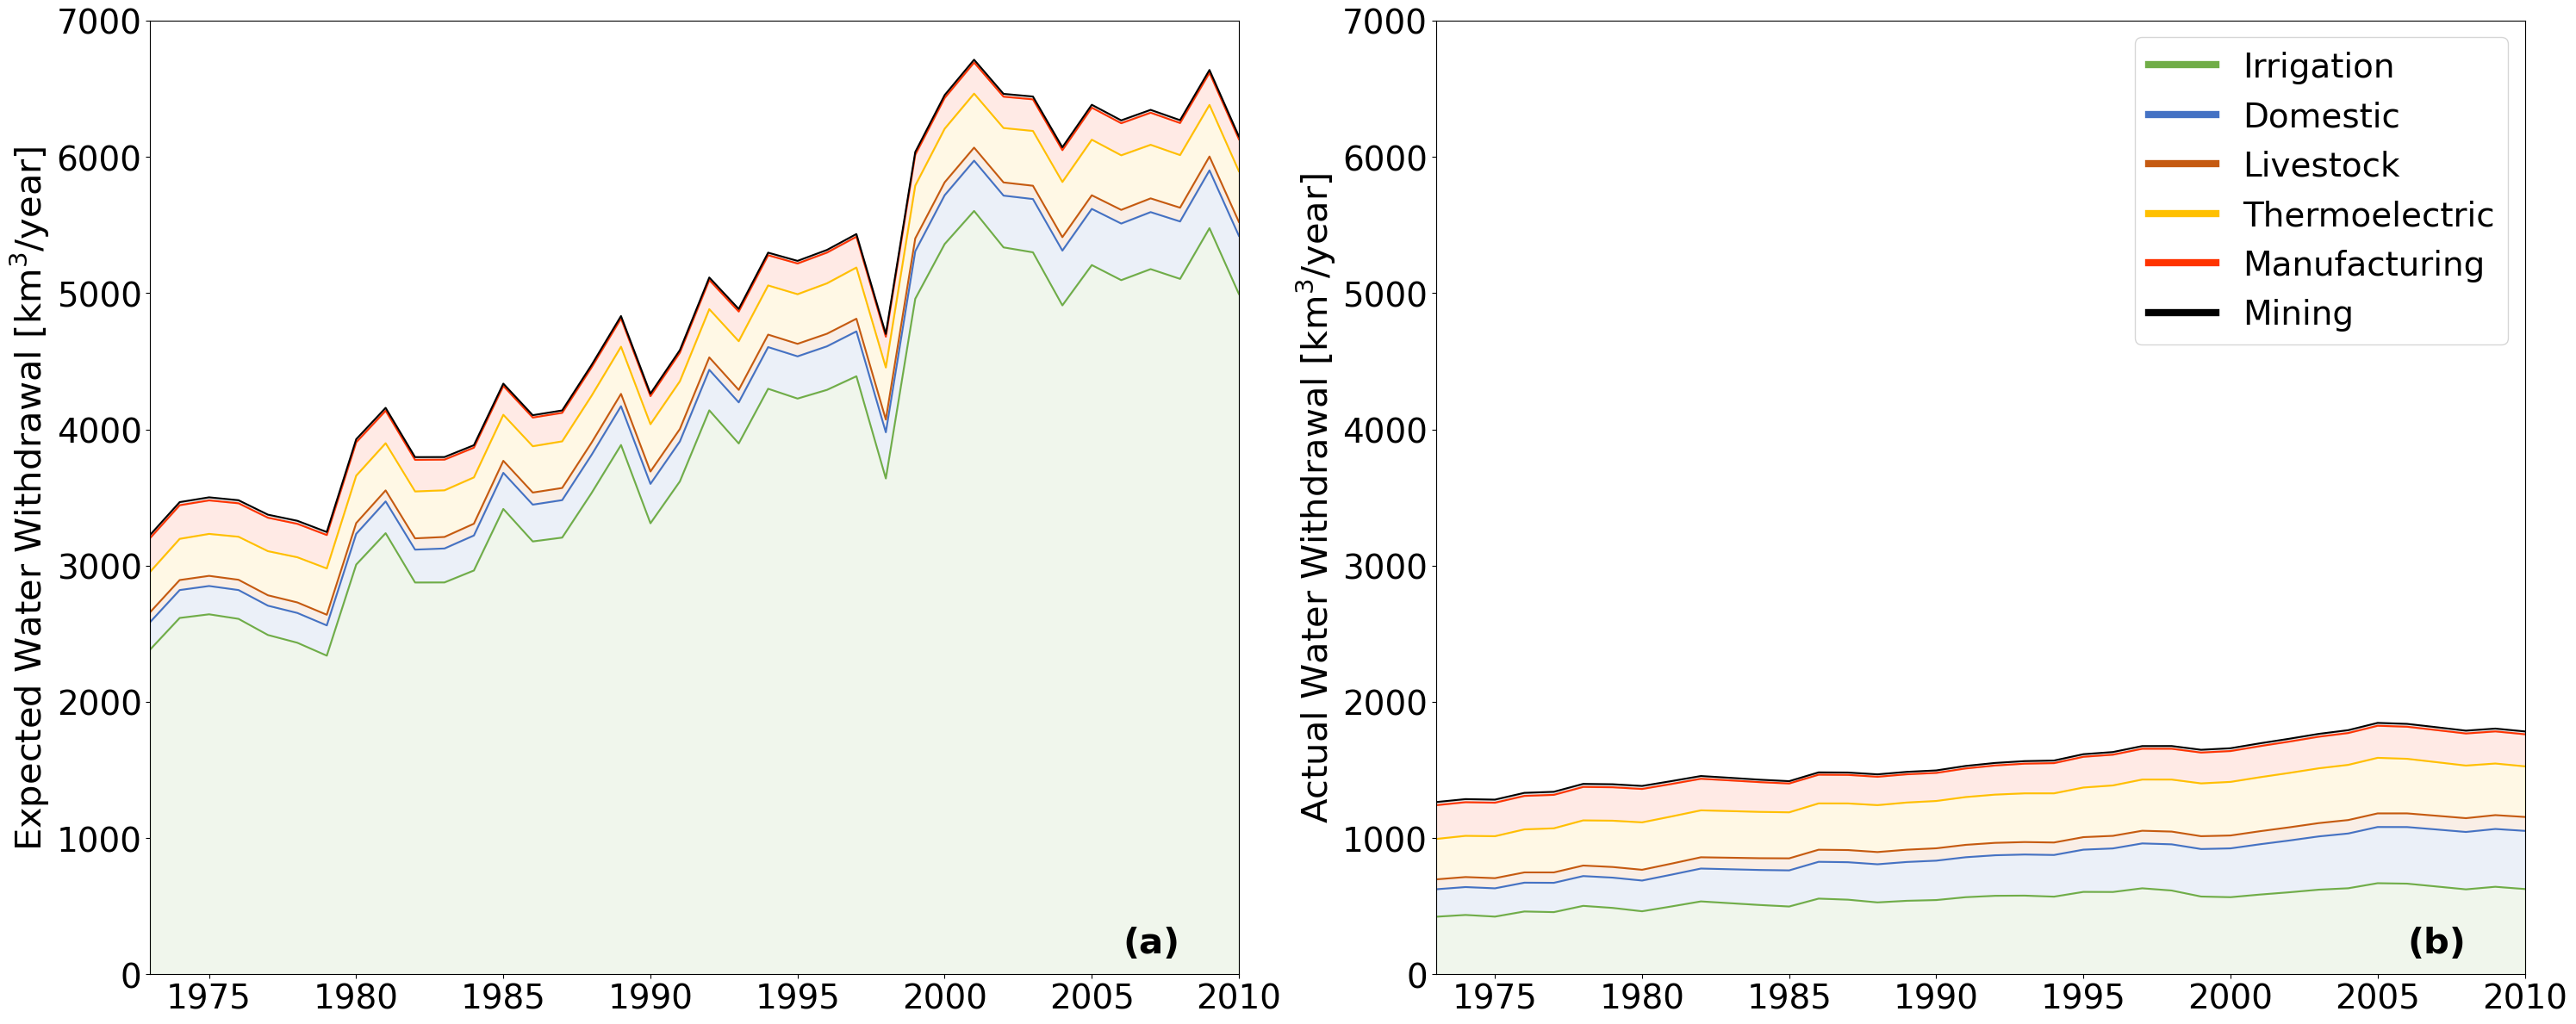

In [17]:
import numpy as np
import matplotlib.pyplot as plt

data_cumulative = np.cumsum(time_series_global_water_abstraction_fluxes, axis=0)
data_cumulative_actual = np.cumsum(time_series_global_water_abstraction_fluxes_actual, axis=0)

variable_names = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining", "Irrigation"]
zero_line = np.zeros(38)
normal_line = np.ones(38)*(-1.0)
interupted_line = np.ones(38)*(-1.0)
years = np.linspace(1973,2010,38)

# Create a figure and a set of subplots with increased size
fig, axs = plt.subplots(1, 2, figsize=(30, 12))  # Increased figure size

# Font sizes
label_font_size = 30  # Font size for labels
tick_font_size = 28   # Font size for ticks
legend_font_size = 28 # Font size for legend
title_font_size = 28  # Font size for title

# plot the cumulative data as a line plot on first subplot
ax = axs[0]

ax.plot(years, time_series_global_water_abstraction_fluxes[10], label=variable_names[5], color="#70ad47")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], label=variable_names[0], color="#4472c4")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], label=variable_names[1], color="#c55a11")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], label=variable_names[2], color="#ffc000")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], label=variable_names[3], color="#ff3300")
ax.plot(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[4], label=variable_names[4], color="#000000")


ax.fill_between(years, zero_line,  time_series_global_water_abstraction_fluxes[10], alpha=0.1, color='#70ad47')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10], time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], alpha=0.1, color='#4472c4')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[0], time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], alpha=0.1, color='#c55a11')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[1], time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], alpha=0.1, color='#ffc000')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[2], time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], alpha=0.1, color='#ff3300')
ax.fill_between(years, time_series_global_water_abstraction_fluxes[10] + data_cumulative[3], time_series_global_water_abstraction_fluxes[10] + data_cumulative[4], alpha=0.1, color='#000000')

# Set larger font sizes for all text elements
# Adjust font sizes
ax.tick_params(labelsize=tick_font_size)
ax.set_ylabel("Expected Water Withdrawal [km$^3$/year]", fontsize=label_font_size)
ax.set_xlim(1973,2010)
ax.set_ylim(0,7000)

# Add label (a) in bold on the right down corner
ax.text(2008, 100, '(a)', fontsize=30, fontweight='bold', va='bottom', ha='right')


# plot the cumulative data as a line plot on second subplot
ax = axs[1]

# define a colormap with five colors
# plot the cumulative data as a line plot
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10], label=variable_names[5], color="#70ad47")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], label=variable_names[0], color="#4472c4")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], label=variable_names[1], color="#c55a11")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], label=variable_names[2], color="#ffc000")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], label=variable_names[3], color="#ff3300")
ax.plot(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[4], label=variable_names[4], color="#000000")


ax.fill_between(years, zero_line,  time_series_global_water_abstraction_fluxes_actual[10], alpha=0.1, color='#70ad47')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], alpha=0.1, color='#4472c4')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[0], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], alpha=0.1, color='#c55a11')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[1], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], alpha=0.1, color='#ffc000')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[2], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], alpha=0.1, color='#ff3300')
ax.fill_between(years, time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[3], time_series_global_water_abstraction_fluxes_actual[10] + data_cumulative[4], alpha=0.1, color='#000000')



# Set larger font sizes for all text elements
ax.tick_params(labelsize=tick_font_size)
leg = ax.legend(fontsize=legend_font_size)
ax.set_ylabel("Actual Water Withdrawal [km$^3$/year]", fontsize=label_font_size)
ax.set_xlim(1973,2010)
ax.set_ylim(0,7000)

# Add label (b) in bold on the right down corner
ax.text(2008, 100, '(b)', fontsize=30, fontweight='bold', va='bottom', ha='right')

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)
    
plt.tight_layout()  # ensures that the subplots do not overlap
plt.savefig("Results/png_format/Sectoral_Withdrawal_1973_2010.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()



# What is the fraction of expected water withdrawal satisfied globally in 2010 square chart

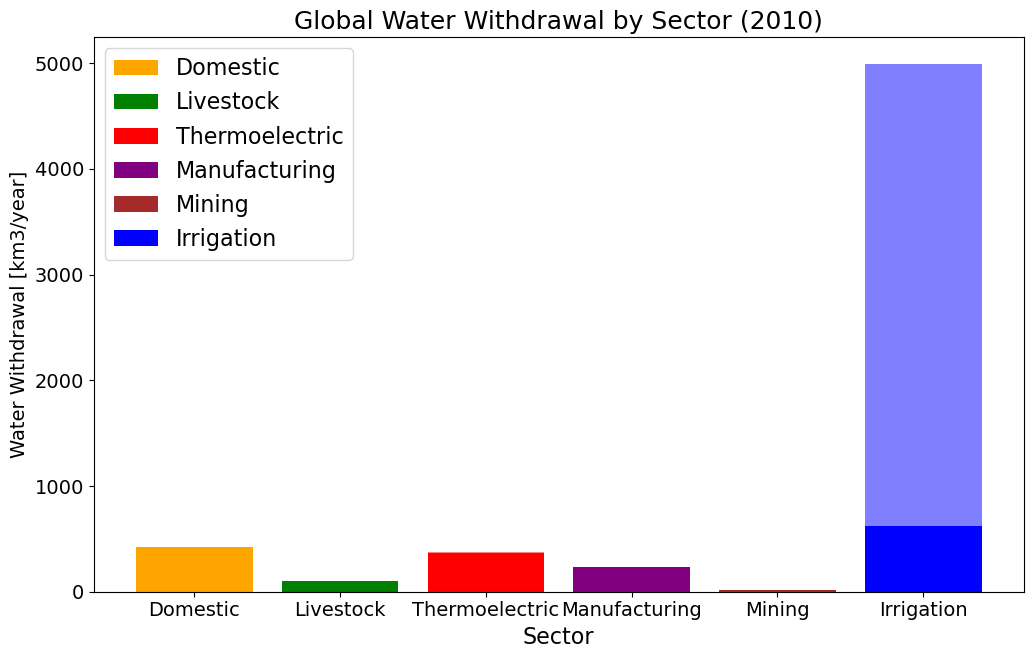

In [21]:
sectors = ['Domestic', 'Livestock', 'Thermoelectric', 'Manufacturing', 'Mining', 'Irrigation']
expected = [time_series_global_water_abstraction_fluxes[0][-1], time_series_global_water_abstraction_fluxes[1][-1], time_series_global_water_abstraction_fluxes[2][-1], time_series_global_water_abstraction_fluxes[3][-1], time_series_global_water_abstraction_fluxes[4][-1], time_series_global_water_abstraction_fluxes[-1][-1]] # in km3 in the year 2010
actual =   [time_series_global_water_abstraction_fluxes_actual[0][-1], time_series_global_water_abstraction_fluxes_actual[1][-1], time_series_global_water_abstraction_fluxes_actual[2][-1], time_series_global_water_abstraction_fluxes_actual[3][-1], time_series_global_water_abstraction_fluxes_actual[4][-1], time_series_global_water_abstraction_fluxes_actual[-1][-1]]

# Colors for each sector
colors = ['orange', 'green', 'red', 'purple', 'brown', 'blue']

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10*1.2, 6*1.2))
ax.bar(sectors, expected, color=colors, alpha=0.5)
ax.bar(sectors, actual, color=colors, alpha=1.0, label = sectors)
ax.legend(fontsize=16) # Increase font size of legend

# Set the chart title and axis labels, and increase font size
ax.set_title('Global Water Withdrawal by Sector (2010)', fontsize=18)
ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Water Withdrawal [km3/year]', fontsize=14)

# Increase font size of tick labels
ax.tick_params(axis='both', labelsize=14)

# Show the chart
plt.show()


In [22]:
# Data for 2010
sectors = ['Domestic', 'Livestock', 'Thermoelectric', 'Manufacturing', 'Mining']
expected = [time_series_global_water_abstraction_fluxes[0][-1], time_series_global_water_abstraction_fluxes[1][-1], time_series_global_water_abstraction_fluxes[2][-1], time_series_global_water_abstraction_fluxes[3][-1], time_series_global_water_abstraction_fluxes[4][-1]] # in km3 in the year 2010
actual =   [time_series_global_water_abstraction_fluxes_actual[0][-1], time_series_global_water_abstraction_fluxes_actual[1][-1], time_series_global_water_abstraction_fluxes_actual[2][-1], time_series_global_water_abstraction_fluxes_actual[3][-1], time_series_global_water_abstraction_fluxes_actual[4][-1]]

# Colors for each sector
colors = ['orange', 'green', 'red', 'purple', 'brown']


# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(sectors, expected, color=colors, alpha=0.5)
ax.bar(sectors, actual, color=colors, alpha=1.0, label = sectors)
ax.legend()

# Set the chart title and axis labels
ax.set_title('Global Water Withdrawal by Sector (2010)')
ax.set_xlabel('Sector')
ax.set_ylabel('Water Withdrawal (Billion Cubic Meters)')

# Show the chart
plt.show()


# What is the fraction of expected water withdrawal satisfied 

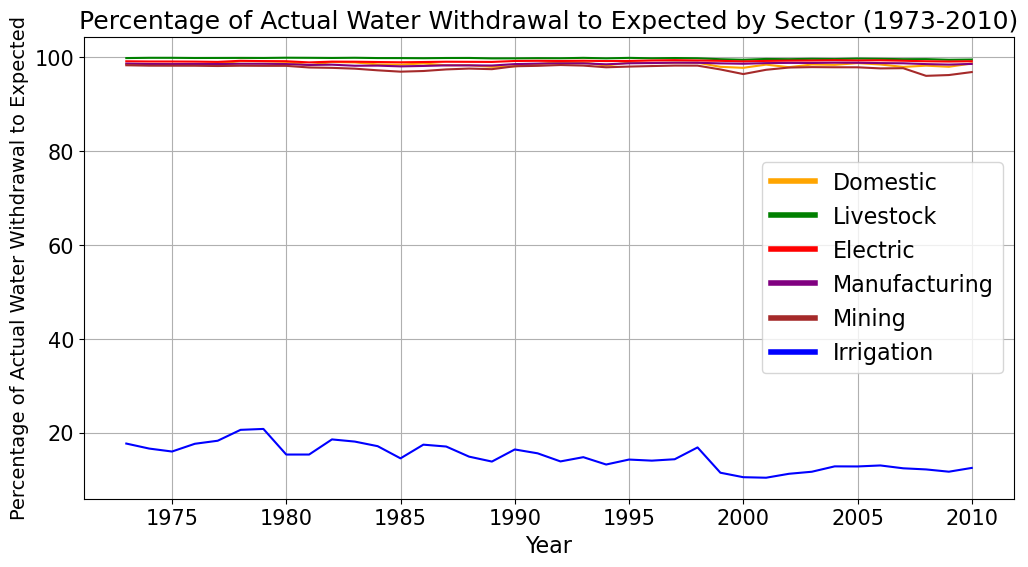

In [23]:
expected_data = {
    'domestic': time_series_global_water_abstraction_fluxes[0],
    'livestock': time_series_global_water_abstraction_fluxes[1],
    'electric': time_series_global_water_abstraction_fluxes[2],
    'manufacturing': time_series_global_water_abstraction_fluxes[3],
    'mining': time_series_global_water_abstraction_fluxes[4],
    'irrigation': time_series_global_water_abstraction_fluxes[-1]
}

actual_data = {
    'domestic': time_series_global_water_abstraction_fluxes_actual[0],
    'livestock': time_series_global_water_abstraction_fluxes_actual[1],
    'electric': time_series_global_water_abstraction_fluxes_actual[2],
    'manufacturing': time_series_global_water_abstraction_fluxes_actual[3],
    'mining': time_series_global_water_abstraction_fluxes_actual[4],
    'irrigation': time_series_global_water_abstraction_fluxes_actual[-1]
}

colors = {
    'domestic': 'orange',
    'livestock': 'green',
    'electric': 'red',
    'manufacturing': 'purple',
    'mining': 'brown',
    'irrigation': 'blue'
}

years = list(range(1973, 2011))

plt.figure(figsize=(12, 6))

for sector in expected_data.keys():
    percentages = [(actual / expected) * 100 for actual, expected in zip(actual_data[sector], expected_data[sector])]
    plt.plot(years, percentages, label=sector.capitalize(), color=colors[sector])

plt.xlabel('Year', fontsize=16) # Increase font size of x-axis label
plt.ylabel('Percentage of Actual Water Withdrawal to Expected', fontsize=14) # Increase font size of y-axis label
plt.title('Percentage of Actual Water Withdrawal to Expected by Sector (1973-2010)', fontsize=18) # Increase font size of title
leg =plt.legend(loc='best', fontsize=16) # Increase font size of legend
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.grid()
plt.tick_params(axis='both', labelsize=15) # Increase font size of tick labels
plt.show()


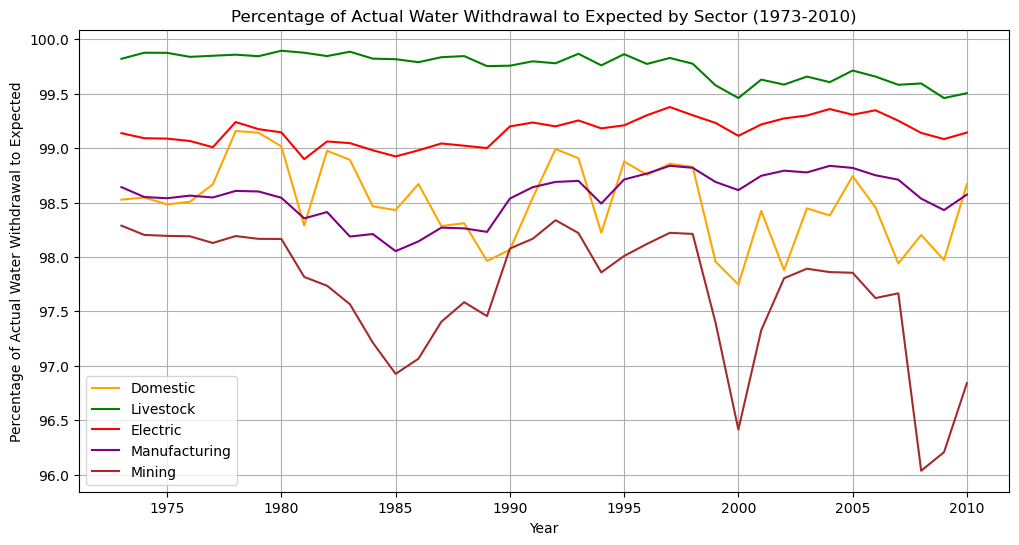

In [24]:
expected_data = {
    'domestic': time_series_global_water_abstraction_fluxes[0],
    'livestock': time_series_global_water_abstraction_fluxes[1],
    'electric': time_series_global_water_abstraction_fluxes[2],
    'manufacturing': time_series_global_water_abstraction_fluxes[3],
    'mining': time_series_global_water_abstraction_fluxes[4],
}

actual_data = {
    'domestic': time_series_global_water_abstraction_fluxes_actual[0],
    'livestock': time_series_global_water_abstraction_fluxes_actual[1],
    'electric': time_series_global_water_abstraction_fluxes_actual[2],
    'manufacturing': time_series_global_water_abstraction_fluxes_actual[3],
    'mining': time_series_global_water_abstraction_fluxes_actual[4],
}

colors = {
    'domestic': 'orange',
    'livestock': 'green',
    'electric': 'red',
    'manufacturing': 'purple',
    'mining': 'brown',
}

years = list(range(1973, 2011))

plt.figure(figsize=(12, 6))

for sector in expected_data.keys():
    percentages = [(actual / expected) * 100 for actual, expected in zip(actual_data[sector], expected_data[sector])]
    plt.plot(years, percentages, label=sector.capitalize(), color=colors[sector])

plt.xlabel('Year')
plt.ylabel('Percentage of Actual Water Withdrawal to Expected')
plt.title('Percentage of Actual Water Withdrawal to Expected by Sector (1973-2010)')
plt.legend(loc='best')
plt.grid()
plt.show()


# What is the recycling ratio for sectors?

In [25]:
withdrawal_data = {
    'domestic': time_series_global_water_abstraction_fluxes[0],
    'livestock': time_series_global_water_abstraction_fluxes[1],
    'electric': time_series_global_water_abstraction_fluxes[2],
    'manufacturing': time_series_global_water_abstraction_fluxes[3],
    'mining': time_series_global_water_abstraction_fluxes[4],
}

consumption_data = {
    'domestic': time_series_global_water_abstraction_fluxes[5],
    'livestock': time_series_global_water_abstraction_fluxes[6],
    'electric': time_series_global_water_abstraction_fluxes[7],
    'manufacturing': time_series_global_water_abstraction_fluxes[8],
    'mining': time_series_global_water_abstraction_fluxes[9],
}

colors = {
    'domestic': 'orange',
    'livestock': 'green',
    'electric': 'red',
    'manufacturing': 'purple',
    'mining': 'brown',
}

years = list(range(1973, 2011))

plt.figure(figsize=(12, 6))

for sector in expected_data.keys():
    percentages = [((withd-cons) / withd) * 100 for withd, cons in zip(withdrawal_data[sector], consumption_data[sector])]
    plt.plot(years, percentages, label=sector.capitalize(), color=colors[sector])

plt.xlabel('Year')
plt.ylabel('Recycle ratio (%)')
plt.title('Percentage of recycled water globally by sectors (1973-2010)')
plt.legend(loc='best')
plt.grid()
plt.show()


# Map actual water withdrawal for each sector in the year 2010:

In [26]:
# Prepare data for mapping for year 2010 for each sector in km3/year:
actual_withd_dom   = (output_data_sectorwater_simulation["DOM_ACTUAL_WITHD"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_liv   = (output_data_sectorwater_simulation["LIV_ACTUAL_WITHD"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_elec  = (output_data_sectorwater_simulation["ELEC_ACTUAL_WITHD"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_mfc   = (output_data_sectorwater_simulation["MFC_ACTUAL_WITHD"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_min   = (output_data_sectorwater_simulation["MIN_ACTUAL_WITHD"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_irrig = (output_data_sectorwater_simulation["QIRRIG_FROM_SURFACE"][0+365*39:365+365*39, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

In [27]:
print(np.nansum(actual_withd_dom))
print(np.nansum(actual_withd_liv))
print(np.nansum(actual_withd_elec))
print(np.nansum(actual_withd_mfc))
print(np.nansum(actual_withd_min))
print(np.nansum(actual_withd_irrig))

421.21716756833916
101.64572627532971
368.4408862108463
232.12649219658277
20.046247349530365
626.0759161227083


In [31]:
total_days_till_2010 = (2010 - 1971) * 365

# Now use total_days to index your dataset
actual_withd_dom_mm   = (output_data_sectorwater_simulation["DOM_ACTUAL_WITHD"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_liv_mm   = (output_data_sectorwater_simulation["LIV_ACTUAL_WITHD"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_elec_mm  = (output_data_sectorwater_simulation["ELEC_ACTUAL_WITHD"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_mfc_mm   = (output_data_sectorwater_simulation["MFC_ACTUAL_WITHD"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_min_mm   = (output_data_sectorwater_simulation["MIN_ACTUAL_WITHD"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
actual_withd_irrig_mm = (output_data_sectorwater_simulation["QIRRIG_FROM_SURFACE"][total_days_till_2010:total_days_till_2010+365, :, :].sum(dim="time").values.flatten()*86400*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))


In [34]:
print(np.nanmax(actual_withd_dom_mm))
print(np.nanmax(actual_withd_liv_mm))
print(np.nanmax(actual_withd_elec_mm))
print(np.nanmax(actual_withd_mfc_mm))
print(np.nanmax(actual_withd_min_mm))
print(np.nanmax(actual_withd_irrig_mm))

250.92342272400856
77.37096436321735
708.9928954839706
180.54476603865623
34.93285719305277
491.2909984588623


In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

projection = ccrs.PlateCarree()  # Change the projection to the default one
cmap = plt.cm.Reds

def plot_background(ax, crs):
    ax.coastlines()
    return ax

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(6.6*3.7, 3.8*2.5), constrained_layout=False, subplot_kw={'projection': projection})  # Adjusted figure size for better layout
axlist = axarr.flatten()

for ax in axlist:
    plot_background(ax, projection)
    ax.set_extent([-180, 180, -60, 90], crs=projection)  # Cut out the Antarctica

cmap   = cmap
bounds = [0.0, 0.01, 0.1, 1, 10, 50, 100, 250, 500, 700]
ticks  = [0.0, 0.01, 0.1, 1, 10, 50, 100, 250, 500, 700]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

for ax, data, title in zip(axlist, [actual_withd_dom_mm, actual_withd_liv_mm, actual_withd_elec_mm, actual_withd_mfc_mm, actual_withd_min_mm, actual_withd_irrig_mm],
                            ['(a) Domestic', 
                             '(b) Livestock', 
                             '(c) Thermoelectric', 
                             '(d) Manufacturing', 
                             '(e) Mining', 
                             '(f) Irrigation']):
    
    masked_data = data  # Use this line for now since we don't have the actual Greenland mask
    ax.pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, masked_data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
    ax.set_title(title, fontsize=24)

# Adjust subplot layout
plt.subplots_adjust(wspace=0.05, hspace=0.2, bottom=0.2)  # Increased hspace for better separation

# Create an extended horizontal colorbar at the bottom
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='horizontal', ticks=ticks, fraction=0.05, pad=0.04, shrink=0.7)
cb.set_label('Annual Actual Withdrawal (mm/year)', size=24, weight='bold')
cb.ax.tick_params(labelsize=22)

# Set the colorbar tick labels
cb.set_ticklabels(['0', '0.01', '0.1', '1', '10', '50', '100', '250', '500', '700'])

plt.savefig("Results/png_format/Map_sectoral_water_withdrawal_2010.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Map average fraction of satisfied demand between years 1981-2010:

In [37]:
fraction_satisfied_dom = output_data_sectorwater_simulation["DOM_ACTUAL_WITHD"][0:365, :, :].sum(dim="time").values.flatten()*mask_lnd_ctsm_f09_g17*0.0
fraction_satisfied_liv = fraction_satisfied_dom.copy()
fraction_satisfied_elec = fraction_satisfied_dom.copy()
fraction_satisfied_mfc = fraction_satisfied_dom.copy()
fraction_satisfied_min = fraction_satisfied_dom.copy()
fraction_satisfied_irrig = fraction_satisfied_dom.copy()

In [38]:
# Define moving time window for each window:
init_time = 365*(1981-1971)
end_time = 365*(1981-1971 + 1)
step = 365  # This will be adjusted for leap years

for year in range(1981, 2011):
    # domestic
    dom_actual_withd_for_given_year = output_data_sectorwater_simulation["DOM_ACTUAL_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    dom_expected_withd_for_given_year = output_data_sectorwater_simulation["DOM_EXPECTED_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(dom_actual_withd_for_given_year), np.logical_and(np.isfinite(dom_expected_withd_for_given_year), dom_expected_withd_for_given_year!=0))

    fraction_satisfied_dom[mask] += np.divide(dom_actual_withd_for_given_year[mask], dom_expected_withd_for_given_year[mask])
    fraction_satisfied_dom[~mask] = np.nan
    
    # livestock
    liv_actual_withd_for_given_year = output_data_sectorwater_simulation["LIV_ACTUAL_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    liv_expected_withd_for_given_year = output_data_sectorwater_simulation["LIV_EXPECTED_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(liv_actual_withd_for_given_year), np.logical_and(np.isfinite(liv_expected_withd_for_given_year), liv_expected_withd_for_given_year!=0))

    fraction_satisfied_liv[mask] += np.divide(liv_actual_withd_for_given_year[mask], liv_expected_withd_for_given_year[mask])
    fraction_satisfied_liv[~mask] = np.nan
    
    # thermoelectric
    elec_actual_withd_for_given_year = output_data_sectorwater_simulation["ELEC_ACTUAL_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    elec_expected_withd_for_given_year = output_data_sectorwater_simulation["ELEC_EXPECTED_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(elec_actual_withd_for_given_year), np.logical_and(np.isfinite(elec_expected_withd_for_given_year), elec_expected_withd_for_given_year!=0))

    fraction_satisfied_elec[mask] += np.divide(elec_actual_withd_for_given_year[mask], elec_expected_withd_for_given_year[mask])
    fraction_satisfied_elec[~mask] = np.nan
    
    # manufacturing
    mfc_actual_withd_for_given_year = output_data_sectorwater_simulation["MFC_ACTUAL_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mfc_expected_withd_for_given_year = output_data_sectorwater_simulation["MFC_EXPECTED_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(mfc_actual_withd_for_given_year), np.logical_and(np.isfinite(mfc_expected_withd_for_given_year), mfc_expected_withd_for_given_year!=0))

    fraction_satisfied_mfc[mask] += np.divide(mfc_actual_withd_for_given_year[mask], mfc_expected_withd_for_given_year[mask])
    fraction_satisfied_mfc[~mask] = np.nan
    
    # mining
    min_actual_withd_for_given_year = output_data_sectorwater_simulation["MIN_ACTUAL_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    min_expected_withd_for_given_year = output_data_sectorwater_simulation["MIN_EXPECTED_WITHD"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(min_actual_withd_for_given_year), np.logical_and(np.isfinite(min_expected_withd_for_given_year), min_expected_withd_for_given_year!=0))

    fraction_satisfied_min[mask] += np.divide(min_actual_withd_for_given_year[mask], min_expected_withd_for_given_year[mask])
    fraction_satisfied_min[~mask] = np.nan
    
    # irrigation
    irrig_actual_withd_for_given_year = output_data_sectorwater_simulation["QIRRIG_FROM_SURFACE"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    irrig_expected_withd_for_given_year = output_data_sectorwater_simulation["QIRRIG_DEMAND"][init_time:end_time, :, :].sum(dim="time").values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    mask = np.logical_and(np.isfinite(irrig_actual_withd_for_given_year), np.logical_and(np.isfinite(irrig_expected_withd_for_given_year), irrig_expected_withd_for_given_year!=0))

    fraction_satisfied_irrig[mask] += np.divide(irrig_actual_withd_for_given_year[mask], irrig_expected_withd_for_given_year[mask])
    fraction_satisfied_irrig[~mask] = np.nan
    
    init_time += step
    end_time  += step
    print("Year completed: " + str(year))

fraction_satisfied_dom /=30 # average 30 years
fraction_satisfied_dom *=100 # fraction to percentage

fraction_satisfied_liv /=30 # average 30 years
fraction_satisfied_liv *=100 # fraction to percentage

fraction_satisfied_elec /=30 # average 30 years
fraction_satisfied_elec *=100 # fraction to percentage

fraction_satisfied_mfc /=30 # average 30 years
fraction_satisfied_mfc *=100 # fraction to percentage

fraction_satisfied_min /=30 # average 30 years
fraction_satisfied_min *=100 # fraction to percentage

fraction_satisfied_irrig /=30 # average 30 years
fraction_satisfied_irrig *=100 # fraction to percentage

Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


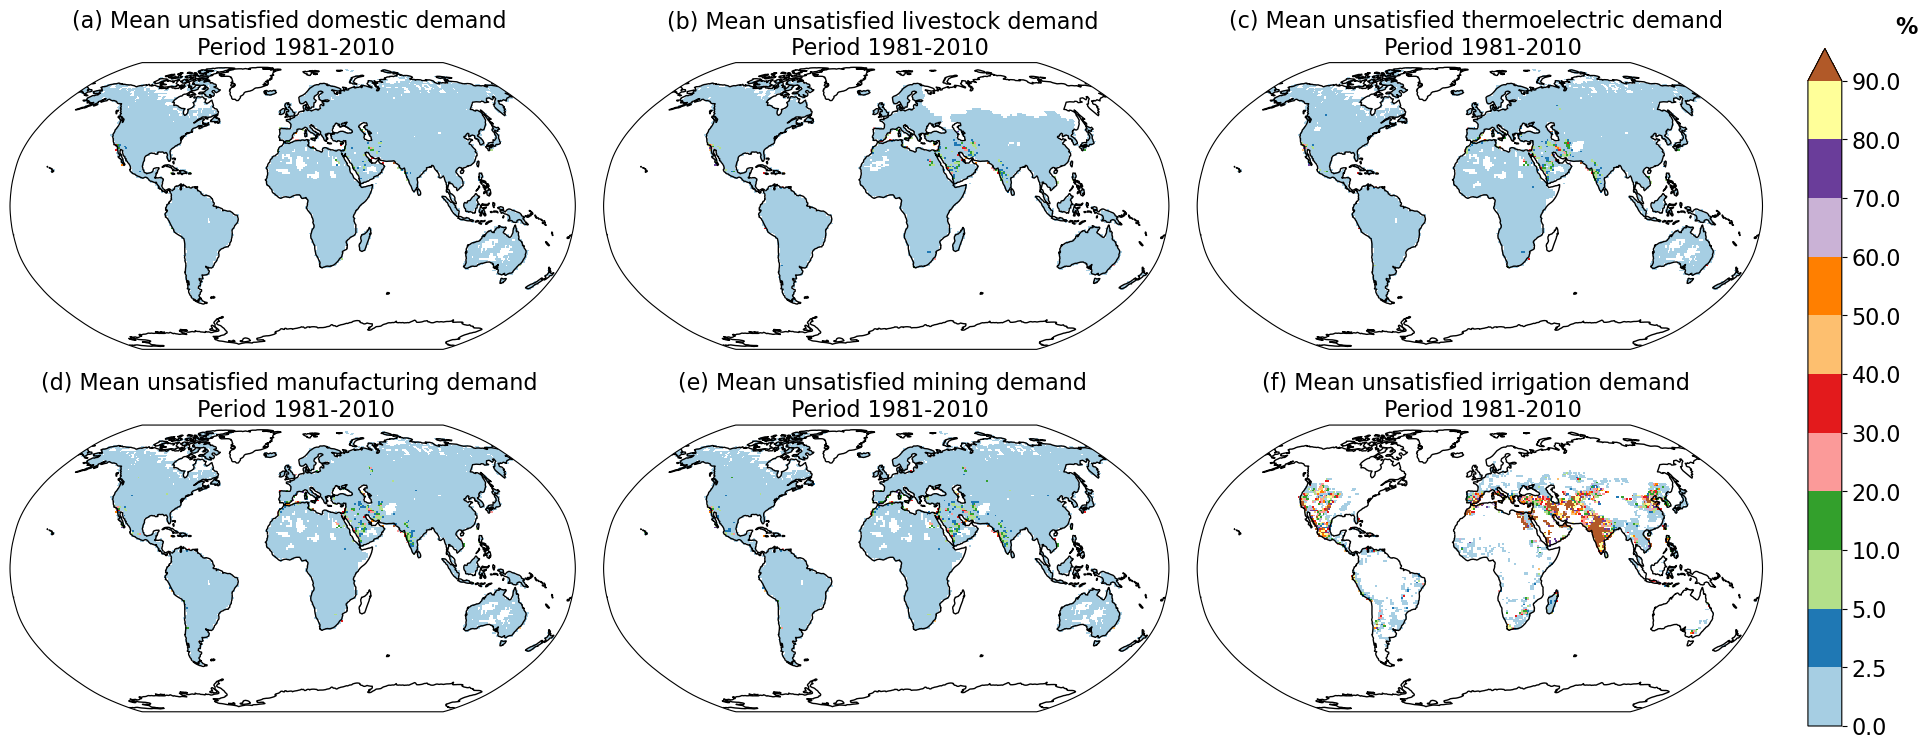

In [39]:
# Plot annual actual withdrawal for all sectors:
projection = ccrs.Robinson()
cmap = plt.cm.Paired
def plot_background(ax, crs):
    ax.coastlines()
    return ax
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(6.6*3.7, 4.4*2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()


for ax in axlist:
    plot_background(ax, projection)


cmap   = cmap
bounds = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
ticks  = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_dom.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[0].set_title('(a) Mean unsatisfied domestic demand \n Period 1981-2010', fontsize=16)

map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_liv.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[1].set_title('(b) Mean unsatisfied livestock demand \n Period 1981-2010', fontsize=16)

map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_elec.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[2].set_title('(c) Mean unsatisfied thermoelectric demand \n Period 1981-2010', fontsize=16)

map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_mfc.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[3].set_title('(d) Mean unsatisfied manufacturing demand \n Period 1981-2010', fontsize=16)

map5 = axlist[4].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_min.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[4].set_title('(e) Mean unsatisfied mining demand \n Period 1981-2010', fontsize=16)

map6 = axlist[5].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_irrig.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
#axlist[0].set_extent([-150, 150, -55, 85], crs=data_crs)
axlist[5].set_title('(f) Mean unsatisfied irrigation demand \n Period 1981-2010', fontsize=16)

plt.subplots_adjust(wspace=0.05, hspace=0.15)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

In [50]:
# create a function to plot the background
def plot_background(ax, crs):
    ax.coastlines()
    return ax

# define the projection and colormap
projection = ccrs.Robinson()
cmap = plt.cm.Paired

# create a figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': projection})
axlist = axs.flatten()
fig.suptitle('Mean unsatisfied domestic water demand\n Period 1981-2010', fontsize=20)

# plot the backgrounds
for ax in axlist:
    plot_background(ax, projection)

# define the colormap and color boundaries
cmap   = cmap
bounds = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
ticks  = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# plot the manufacturing sector on the first plot
map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_dom.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
# axlist[0].set_title('Mean unsatisfied domestic demand \n Period 1981-2010', fontsize=16)

# add a colorbar for all plots
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

# plot zoom over North America on the second plot
axlist[1].set_extent([-170, -30, 0, 90], crs=ccrs.PlateCarree())
plot_background(axlist[1], projection)
map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_dom.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Europe and North Africa on the third plot
axlist[2].set_extent([-20, 60, 10, 70], crs=ccrs.PlateCarree())
plot_background(axlist[2], projection)
map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_dom.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Middle East, India and China on the fourth plot
axlist[3].set_extent([60, 140, 5, 50], crs=ccrs.PlateCarree())
plot_background(axlist[3], projection)
map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_dom.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

plt.savefig("Results/png_format/Map_unsatisfied_demand_domestic.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
# show the plot
plt.show()


In [49]:
# create a function to plot the background
def plot_background(ax, crs):
    ax.coastlines()
    return ax

# define the projection and colormap
projection = ccrs.Robinson()
cmap = plt.cm.Paired

# create a figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': projection})
axlist = axs.flatten()

fig.suptitle('Mean unsatisfied livestock water demand\n Period 1981-2010', fontsize=20)

# plot the backgrounds
for ax in axlist:
    plot_background(ax, projection)

# define the colormap and color boundaries
cmap   = cmap
bounds = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
ticks  = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# plot the manufacturing sector on the first plot
map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_liv.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
# axlist[0].set_title('Mean unsatisfied livestock demand \n Period 1981-2010', fontsize=16)

# add a colorbar for all plots
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

# plot zoom over North America on the second plot
axlist[1].set_extent([-170, -30, 0, 90], crs=ccrs.PlateCarree())
plot_background(axlist[1], projection)
map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_liv.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Europe and North Africa on the third plot
axlist[2].set_extent([-20, 60, 10, 70], crs=ccrs.PlateCarree())
plot_background(axlist[2], projection)
map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_liv.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Middle East, India and China on the fourth plot
axlist[3].set_extent([60, 140, 5, 50], crs=ccrs.PlateCarree())
plot_background(axlist[3], projection)
map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_liv.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

plt.savefig("Results/png_format/Map_unsatisfied_demand_livestock.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
# show the plot
plt.show()


In [48]:
# create a function to plot the background
def plot_background(ax, crs):
    ax.coastlines()
    return ax

# define the projection and colormap
projection = ccrs.Robinson()
cmap = plt.cm.Paired

# create a figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': projection})
axlist = axs.flatten()
fig.suptitle('Mean unsatisfied manufacturing water demand\n Period 1981-2010', fontsize=20)

# plot the backgrounds
for ax in axlist:
    plot_background(ax, projection)

# define the colormap and color boundaries
cmap   = cmap
bounds = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
ticks  = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# plot the manufacturing sector on the first plot
map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_mfc.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
# axlist[0].set_title('Mean unsatisfied manufacturing demand \n Period 1981-2010', fontsize=16)

# add a colorbar for all plots
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

# plot zoom over North America on the second plot
axlist[1].set_extent([-170, -30, 0, 90], crs=ccrs.PlateCarree())
plot_background(axlist[1], projection)
map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_mfc.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Europe and North Africa on the third plot
axlist[2].set_extent([-20, 60, 10, 70], crs=ccrs.PlateCarree())
plot_background(axlist[2], projection)
map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_mfc.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Middle East, India and China on the fourth plot
axlist[3].set_extent([60, 140, 5, 50], crs=ccrs.PlateCarree())
plot_background(axlist[3], projection)
map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_mfc.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

plt.savefig("Results/png_format/Map_unsatisfied_demand_manufacturing.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)

# show the plot
plt.show()


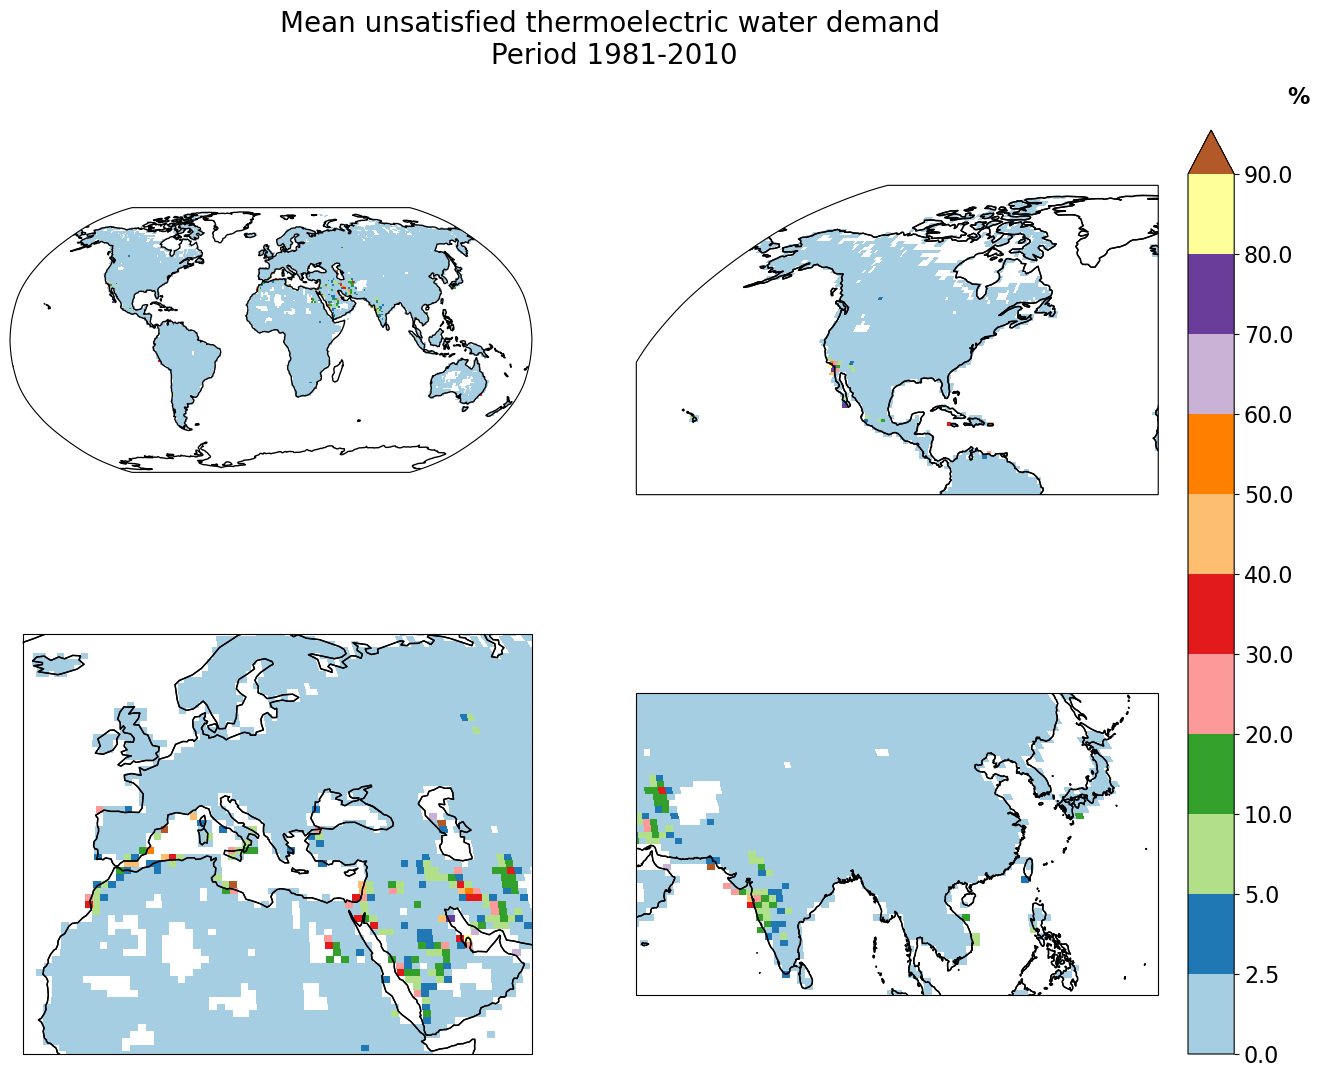

In [47]:
# create a function to plot the background
def plot_background(ax, crs):
    ax.coastlines()
    return ax

# define the projection and colormap
projection = ccrs.Robinson()
cmap = plt.cm.Paired

# create a figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': projection})
axlist = axs.flatten()
fig.suptitle('Mean unsatisfied thermoelectric water demand\n Period 1981-2010', fontsize=20)

# plot the backgrounds
for ax in axlist:
    plot_background(ax, projection)

# define the colormap and color boundaries
cmap   = cmap
bounds = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
ticks  = [0.0, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# plot the electric sector on the first plot
map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_elec.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
# axlist[0].set_title('Mean unsatisfied thermoelectric demand \n Period 1981-2010', fontsize=16)

# add a colorbar for all plots
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

# plot zoom over North America on the second plot
axlist[1].set_extent([-170, -30, 0, 90], crs=ccrs.PlateCarree())
plot_background(axlist[1], projection)
map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_elec.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Europe and North Africa on the third plot
axlist[2].set_extent([-20, 60, 10, 70], crs=ccrs.PlateCarree())
plot_background(axlist[2], projection)
map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_elec.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Middle East, India and China on the fourth plot
axlist[3].set_extent([60, 140, 5, 50], crs=ccrs.PlateCarree())
plot_background(axlist[3], projection)
map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_elec.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

plt.savefig("Results/png_format/Map_unsatisfied_demand_thermoelectric.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)


# show the plot
plt.show()


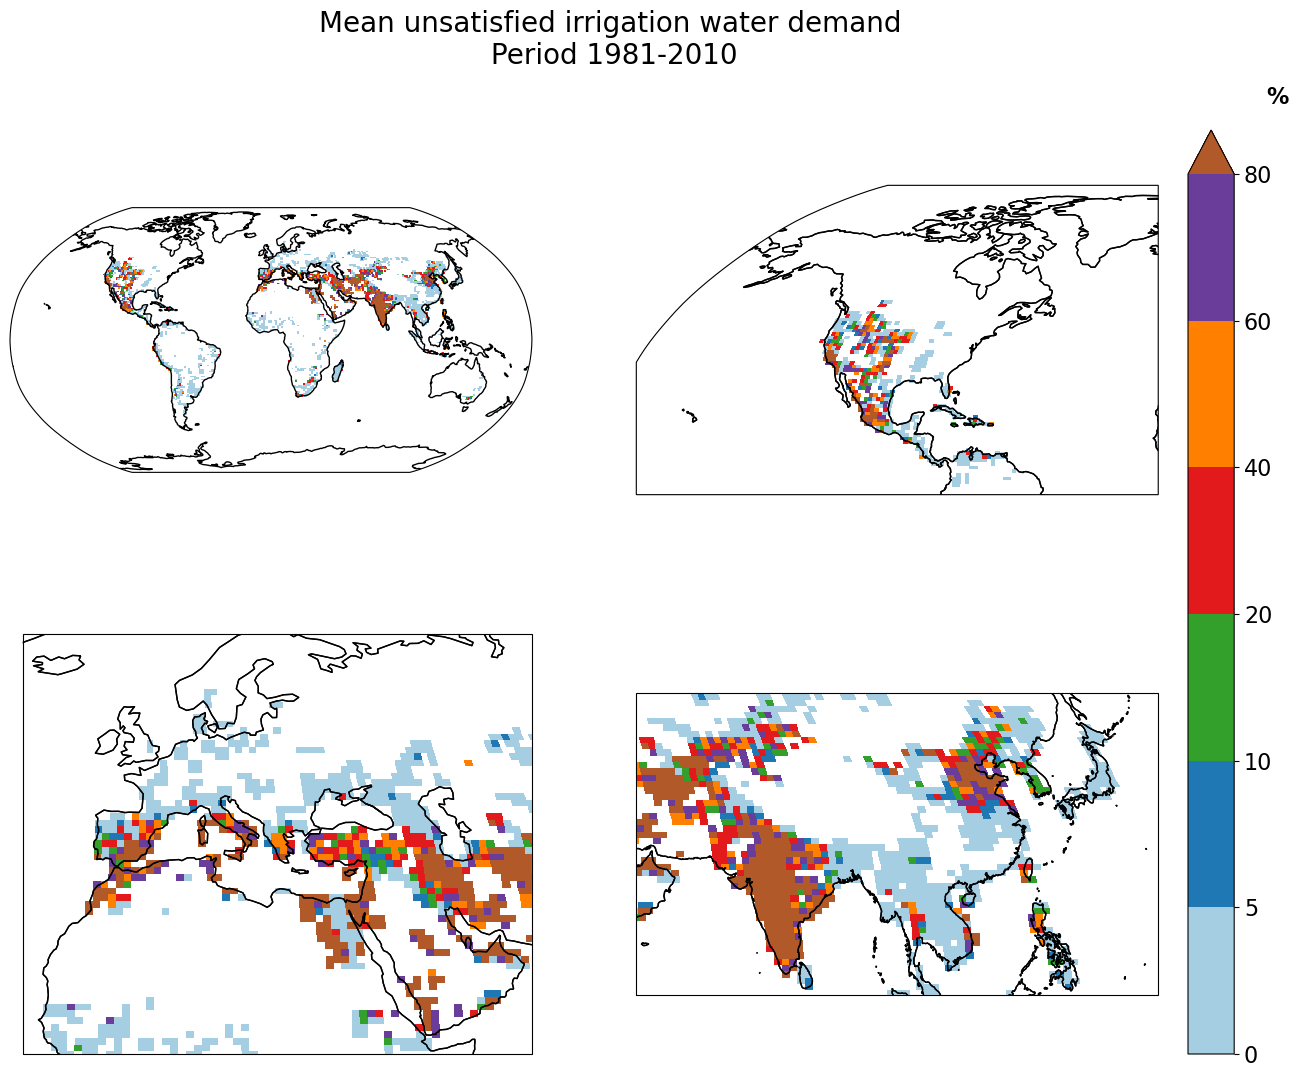

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl

# create a function to plot the background
def plot_background(ax, crs):
    ax.coastlines()
    return ax

# define the projection and colormap
projection = ccrs.Robinson()
cmap = plt.cm.Paired

# create a figure and axis objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), subplot_kw={'projection': projection})
fig.suptitle('Mean unsatisfied irrigation water demand\n Period 1981-2010', fontsize=20)
axlist = axs.flatten()

# plot the backgrounds
for ax in axlist:
    plot_background(ax, projection)

# define the colormap and color boundaries
cmap   = cmap
bounds = [0.0, 5, 10, 20, 40, 60, 80]
ticks  = [0.0, 5, 10, 20, 40, 60, 80]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# plot the manufacturing sector on the first plot
map1 = axlist[0].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_irrig.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over North America on the second plot
axlist[1].set_extent([-170, -30, 0, 90], crs=ccrs.PlateCarree())
plot_background(axlist[1], projection)
map2 = axlist[1].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_irrig.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Europe and North Africa on the third plot
axlist[2].set_extent([-20, 60, 10, 70], crs=ccrs.PlateCarree())
plot_background(axlist[2], projection)
map3 = axlist[2].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_irrig.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)

# plot zoom over Middle East, India and China on the fourth plot
axlist[3].set_extent([60, 140, 5, 50], crs=ccrs.PlateCarree())
plot_background(axlist[3], projection)
map4 = axlist[3].pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, 100.0 - fraction_satisfied_irrig.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])), cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)


# add a colorbar for all plots
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical', ticks=ticks, fraction=0.05,  pad=0.024)
cb.set_label('%', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

plt.savefig("Results/png_format/Map_unsatisfied_demand_irrigation.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)

# show the plot
plt.show()
